In [1]:
import os,sys
sys.path.append('misc/lib/python3.7/site-packages')
#PigmentHunter is added for a file path

from IPython.display import display
import math
import numpy as np
import nglview as nv
import matplotlib.pyplot as plt
import parmed as pmd
import numpy.random as random
import re
import requests
from hubzero.submit.SubmitCommand import SubmitCommand
import time
import hublib.tool as tool
import hublib.ui as ui
import ipywidgets as widgets


from IPython.display import Javascript, display


class ExcStruc:
    def __init__(self):
        self.nres = 0
        self.resnums = []
        self.restypes = []
        self.ham = []
        self.dips = []
        self.cents = []
            
    def reset(self):
        self.nres = 0
        self.resnums = []
        self.restypes = []
        self.ham = []
        self.dips = []
        self.cents = []

class RepList:
    def __init__(self):
        self.component_id = ''
        self.params = []
        self.names = []
        self.reps = list()
        
    def reset(self):
        self.component_id = ''
        self.params = []
        self.names = []
        self.reps = list()
        
    def append(self, nrep):
        self.names.append(nrep.name)
        ptext = {"type": nrep.type, "params": {"color": nrep.color, "sele": nrep.selection, "opacity": str(nrep.opacity)}}
        self.params.append(ptext)
        self.reps.append(nrep)
        
class NGLRep:
    def __init__(self, name, rtype, sel, col, opac):
        self.name = name
        self.type = rtype
        self.selection = sel
        self.color = col
        self.opacity = opac

def check_atoms(RefAtNames, QuerAtNames):
    ismatch = True
    for atnm in RefAtNames:
        if(QuerAtNames.count(atnm)!=1):
            ismatch = False
    return ismatch

def find_porph(pmdstruc, xtruc):
    PORatList = list(['NA', 'NB', 'NC', 'ND'])
    for n in range(0, len(pmdstruc.residues)):
        r = pmdstruc.residues[n]
        nmlist = list()
        for at in r:
            nmlist.append(at.name)
        if(check_atoms(PORatList, nmlist)):
            if(nmlist.count('MG')==1):
                xstruc.resnums.append(n)
                xstruc.nres += 1 
                xstruc.restypes.append('CHL')
                
            else:
                xstruc.resnums.append(n)
                xstruc.nres += 1 
                xstruc.restypes.append('PHO')

    return


def find_dipoles(struc,xtruc):
    ResNums = xtruc.resnums
    DipMat = np.zeros((len(ResNums),3))
    for n in range(0, len(ResNums)):
        r = struc.residues[ResNums[n]]
        for at in r:
            if at.name=='NB':
                NB = struc.coordinates[at.idx]
            if at.name=='ND':
                ND = struc.coordinates[at.idx]
        DipMat[n,:] = NB - ND
    xtruc.dips = DipMat

def find_centers(struc, xtruc):
    ResNums = xtruc.resnums
    CentMat = np.zeros((len(ResNums),3))
    for n in range(0, len(ResNums)):
        r = struc.residues[ResNums[n]]
        cent = 0.0
        for at in r:
            if at.name=='NB':
                cent += 0.5*struc.coordinates[at.idx]
            if at.name=='ND':
                cent += 0.5*struc.coordinates[at.idx]
        CentMat[n,:] = cent
    xtruc.cents = CentMat

def sync_widgets_to_rep(rep):
    seldrop.value = rep.name
    styledrop.value = rep.type
    colordrop.value = rep.color
    opacslide.value = int(rep.opacity*100)
    
def sync_rep_to_widgets():
    global rList
    num = rList.names.index(seldrop.value)
    rep = rList.reps[num]
    rep.type = styledrop.value
    rep.name = seldrop.value
    rep.color = colordrop.value
    rep.opacity = opacslide.value*0.01
    ptext = {"type": rep.type, "params": {"color": rep.color, "sele": rep.selection, "opacity": str(rep.opacity)}}
    rList.params[num] = ptext
    pdbview.set_representations(rList.params)
    

def std_rep(nglview, nvstruc, xstruc):
    global rList
    pdbview.add_trajectory(struc)
    pdbview.clear(0)
    chltxt = ''
    photxt = ''
    for n in range(0, len(xstruc.resnums)):
        if xstruc.restypes[n]=='CHL':
            if len(chltxt)>0:
                chltxt += ' or '
            chltxt += str(xstruc.resnums[n]+1)
        if xstruc.restypes[n]=='PHO':
            if len(photxt)>0:
                photxt += ' or '
            photxt += str(xstruc.resnums[n]+1)
    
    rList.append(NGLRep("Protein", "cartoon", "protein", "grey", 0.2))
    if len(chltxt)>0:
        rList.append(NGLRep("Chlorophyll", "licorice", chltxt, "green", 1.0))
    if len(photxt)>0:
        rList.append(NGLRep("Pheophytin", "licorice", photxt, "blue", 1.0))
    
    pdbview.set_representations(rList.params)
    
    seldrop.options=rList.names
    seldrop.disabled=False
    
    styledrop.disabled=False
    
    colordrop.disabled=False
    opacslide.disabled=False
    sync_widgets_to_rep(rList.reps[0])
    
    for n in range(0, np.shape(xstruc.dips)[0]):
        cent = xstruc.cents[n,:]
        dip = xstruc.dips[n,:]
        v1 = cent - 1.5*dip
        v2 = cent + 1.5*dip
        pdbview.shape.add_arrow(v1.tolist(), v2.tolist(), [1,0,0 ], 1.0 )
        
        
pdbid = widgets.Text(
    value='2DRE',
    placeholder='Type something',
    description='PDB ID:',
    layout = widgets.Layout(width='4cm'),
    disabled=False
)

pdbgo = widgets.Button(
    description='Display',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to display the pdb file',
    icon='' # (FontAwesome names without the `fa-` prefix)
)

pdboutput = widgets.HTML(
    value="",
    placeholder='',
    description='',
)

Output = widgets.Output()

def clear_stage(view):
    view._clear_component_auto_completion()
    if view._trajlist:
        for traj in view._trajlist:
            view._trajlist.remove(traj)
    for component_id in view._ngl_component_ids:
        component_index = view._ngl_component_ids.index(component_id)
        view._ngl_component_ids.remove(component_id)
        view._ngl_component_names.pop(component_index)
        view._remote_call('removeComponent',
            target='Stage',
            args=[component_index,])
    # Shapes appear not to be populated in component_id list.
    # So we have to call seperately removeAllComponents to 
    # get rid of them. 
    view._remote_call('removeAllComponents',
            target='Stage',
            args=[0])
    view._update_component_auto_completion()


def pdbgo_onclick(b):
    global struc
    global estruc
    url = 'http://files.rcsb.org/download/'+pdbid.value+'.pdb'
    r = requests.get(url, allow_redirects=True)
    if(r.status_code==200):
        fname = pdbid.value + '.pdb'
        wfd = open(fname, 'wb')
        wfd.write(r.content)
        wfd.close()
        pdboutput.value = ''
        
        xstruc.reset()
        clear_stage(pdbview)
        rList.reset()
        struc = pmd.load_file(fname)
        find_porph(struc, xstruc)
        find_dipoles(struc, xstruc)
        find_centers(struc, xstruc)
        std_rep(pdbview, struc, xstruc)

    else:
        pdboutput.value = 'Please enter a valide PDB ID code.'

        
xstruc = ExcStruc()
pdbgo.on_click(pdbgo_onclick)
pdbid.on_submit(pdbgo_onclick)
pdbview = nv.NGLWidget()
pdbview._set_size('500px', '500px')
pdbbox = widgets.HBox([pdbid, pdbgo])
rList = RepList()


seldrop = widgets.Dropdown(
    options=rList.names,
    #value='Protein',
    description='Selection:',
    disabled=True,
)


styledrop = widgets.Dropdown(
    options=['cartoon', 'licorice', 'spacefill'],
    description='Style:',
    disabled=True,
)

colordrop = widgets.Dropdown(
    options=['chain', 'red', 'green', 'blue', 'grey'],
    description='Color:',
    disabled=True,
)

opacslide = widgets.IntSlider(
    min=0,
    max=100,
    step=1,
    description='Opacity:',
    disabled=True,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

dispbox = widgets.VBox([seldrop, styledrop, colordrop, opacslide])
viewbox = widgets.HBox([pdbview, dispbox])


def seldrop_on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        rep = rList.reps[rList.names.index(seldrop.value)]
        sync_widgets_to_rep(rep)
        
def styledrop_on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        num = rList.names.index(seldrop.value)
        rep = rList.reps[num]
        rep.type = styledrop.value
        ptext = {"type": rep.type, "params": {"color": rep.color, "sele": rep.selection, "opacity": str(rep.opacity)}}
        rList.params[num] = ptext
        pdbview.set_representations(rList.params)
        
def colordrop_on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        num = rList.names.index(seldrop.value)
        rep = rList.reps[num]
        rep.color = colordrop.value
        ptext = {"type": rep.type, "params": {"color": rep.color, "sele": rep.selection, "opacity": str(rep.opacity)}}
        rList.params[num] = ptext
        pdbview.set_representations(rList.params)
        
def opacslide_on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        num = rList.names.index(seldrop.value)
        rep = rList.reps[num]
        rep.opacity = opacslide.value*0.01
        ptext = {"type": rep.type, "params": {"color": rep.color, "sele": rep.selection, "opacity": str(rep.opacity)}}
        rList.params[num] = ptext
        pdbview.set_representations(rList.params)

seldrop.observe(seldrop_on_change)
styledrop.observe(styledrop_on_change)
colordrop.observe(colordrop_on_change)
opacslide.observe(opacslide_on_change)
    
inprogress = False
        
display(pdbbox)
display(pdboutput)
display(viewbox)
struc = pmd.structure

<IPython.core.display.Javascript object>

HTML(value='', placeholder='')

In [3]:
class amide(object): #defines amide class
    def __init__(self,C,N,H,O,isPro,CAC,CAN):
        self.C=C
        self.N=N
        self.H=H
        self.O=O
        self.isPro=isPro
        self.CAC=CAC
        self.CAN=CAN
        
    


In [5]:
angle=10
dip_mat=[]#will record the dipole and vector as Cx,Cy,Cz,Ox,Oy,Oz,length
bond_list=[]
C_coord=[]#recorded versions of c_coord
O_coord=[]#recorded version of o_coord
for cat in struc:
    if cat.atomic_number==6: #pulling only carbons
        if len(cat.bond_partners)==3:
            if cat.name=="C": # pulling only carbons labeled as C another solution will need to be found
                H_id=-1#resets H_id for each loop because this could be conditional
                N_id=-1
                O_id=-1
                C_id=-1
                CAC_id=-1
                CAN_id=-1
                found_N=False
                found_CAC=False
                found_O=False
            
                NC_bonds=0#reset parameter to determine if proline
                C_id=cat.idx
                bonds=cat.bond_partners
                for n in range (0,len(bonds)): #this assumes your carbon has a double bonded oxygen, and a single bonded nitrogen and carbon to your central carbon
                    if bonds[n].atomic_number==7: #finds the nitrgoen bound to carbon C
                        N_id=bonds[n].idx
                        found_N=True
                        
                    if bonds[n].atomic_number==6: #finds the carbon (CA) bound to carbon c
                        CAC_id=bonds[n].idx
                        found_CAC=True
                        
                    if bonds[n].atomic_number==8: # finds the oxygen bound to cabron c
                        O_id=bonds[n].idx
                        found_O=True
                if found_N and found_CAC and found_O:
                    N_bonds=struc[N_id].bond_partners
                    cat_numbers=[]
                    at_numbers=[]#records everything 
                    for at in N_bonds:
                        at_numbers.append(at.idx)
                        if at.atomic_number==1:
                            H_id=at.idx
                        if at.atomic_number==6:#done so only carbons are recorded
                            if at.idx != C_id:
                                cat_numbers.append(at.idx)#records the id number so that they can be recalled
                          
                    if len(cat_numbers)==2: #proline will have three carbon bonds C, gamma carbon and alpha carbon
                        pro=True
                        
                        for n in range (0,len(cat_numbers)):
                            CAT_bonds=struc[cat_numbers[n]].bond_partners #call cat bonds
                            cneighbors=0
            
                            for p in range (0,len(CAT_bonds)):
                                if CAT_bonds[p].atomic_number==6:
                                    cneighbors+=1
                            if cneighbors==2:
                                CAN_id=cat_numbers[n]
                            if cneighbors==1:
                                H_id=cat_numbers[n]
                                       
                    if len(cat_numbers)==1:#non proline will have two carbons and one hydrogen
                        pro=False
                        CAN_id=cat_numbers[0]
 

                bond_list.append(amide(C_id,N_id,H_id,O_id,pro,CAC_id,CAN_id))
Nbonds=len(bond_list)
Cndcs=np.zeros((Nbonds,),dtype="int")
Ondcs=np.zeros((Nbonds,),dtype="int")
Nndcs=np.zeros((Nbonds,),dtype="int")
Hndcs=np.zeros((Nbonds,),dtype="int")
for n in range (0,Nbonds):
    Cndcs[n]=bond_list[n].C
    Ondcs[n]=bond_list[n].O
    Nndcs[n]=bond_list[n].N
    Hndcs[n]=bond_list[n].H

C_coord=struc.coordinates[Cndcs]
O_coord=struc.coordinates[Ondcs]
N_coord=struc.coordinates[Nndcs]
H_coord=struc.coordinates[Hndcs]
axis=np.cross((O_coord-C_coord),(C_coord-N_coord))
dip_mat = (O_coord-C_coord-N_coord*0.01)/(np.sqrt(np.sum(np.power(O_coord-C_coord-N_coord*0.01,2),0)))
for n in range(0, np.shape(dip_mat)[0]):
      dip_mat[n,:] = dip_mat[n,:] / np.linalg.norm(dip_mat[n,:])
cent_mat=0.5*(O_coord+C_coord)#R1 and R2

coupling_matrix=np.zeros((Nbonds,Nbonds))
ANG2CM=1E-8

PREFAC=(0.12*((1e-18)**2)*(1e-7))/((6.626e-34)*(2.99792458e10)*(ANG2CM**3)) #converts to debye**2

for m in range (0, Nbonds):
    for n in range  (0,m-1):
        R1=cent_mat[m]
        R2=cent_mat[n]
        r=np.linalg.norm(R2-R1)
        Rhat=(R2-R1)/r
        dip1=dip_mat[m]
        dip2=dip_mat[n]
        coupling=PREFAC*(np.dot(dip1,dip2)-3*np.dot(dip1,Rhat)*np.dot(dip2,Rhat))/((r)**3)                        
        coupling_matrix[m,n]=coupling

coupling_matrix +=np.transpose(coupling_matrix)

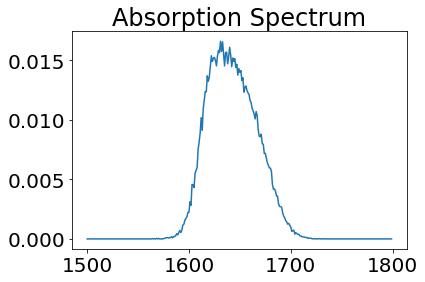

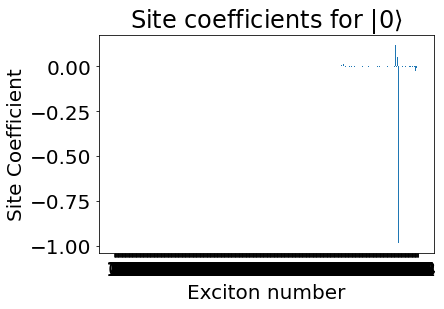

In [6]:
#np.linalg.norm(dip_mat[0,:]) ##should be 1
import math
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import time
import numpy as np
plt.rcParams.update({'font.size': 20})
np.set_printoptions(suppress=True, precision=3)

# Set parameters -- all frequencies/energies are in 1/cm
vo = 1650              # Site energy -- identical for all sites
V = -100                # Coupling constant
Nosc = Nbonds               # Number of oscillators
Mu = dip_mat  # Dipole moment matrix
v1 = 1500
v2 = 1800
dv = 1
vaxis = np.arange(v1,v2,dv)
spec = np.zeros(np.shape(vaxis))
#1650 is amide 1 
# Build the Hamiltonian matrix -- we use frequency in 1/cm
Nreps=100
for n in range (0,Nreps):
    H = coupling_matrix+np.eye(Nbonds)*(np.diag(np.random.normal(1650,20,(Nbonds,)))) #replace with variables

    # Generate a random ensemble of site energies, diagonalize, and add results to spectrum
    eVals,eVecs = np.linalg.eig(H)
    eMu = np.matmul(np.transpose(eVecs), Mu)
    for n in range(0,Nbonds):
        if eVals[n]>v1 and eVals[n]<v2:
            ndx = np.where(np.abs(vaxis-eVals[n])==np.min(np.abs(vaxis-eVals[n])))[0][0]
            spec[ndx] += ((np.linalg.norm(eMu[n,:]))**2)/Nosc

spec/=Nreps
# Plot the spectrum
plt.figure()
plt.plot(vaxis, spec)
plt.title('Absorption Spectrum')

# Plot the site coefficients for the lowest-energy eigenstate
plt.figure()
plt.bar(np.arange(0,Nosc), eVecs[:,0])
plt.title('Site coefficients for $|0 \\rangle$')
plt.xticks(range(0,Nosc))
plt.xlabel('Exciton number')
plt.ylabel('Site Coefficient')
plt.show()